# Мобильная игра «Космические братья»
# Анализ рекламных источников

#### ЦЕЛЬ:  проанализировать поведения игроков в зависимости от источника перехода и дать рекомендации по ментетезации игры

#### ЗАДАЧИ:
- провести исследовательский анализ данных;
- проанализировать влияние источника перехода в игру на поведение пользователя;
- проверьте статистические гипотезы
    

#### Оисание данных:
Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий (building — объект построен, finished_stage_1 — первый уровень завершён, project — проект завершён)
- `building_type` — один из трёх типов здания (assembly_shop — сборочный цех, spaceport — космопорт, research_center — исследовательский центр)
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта

Датасет *ad_cost.csv*:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

#### Структура проекта:

 1. Изучение общей информации    *[jump to code cell 1](#cell1)
 2. Преобработка данных          *[jump to code cell 2](#cell2)
 3. Анализ данных:
      - Анализ поведения игроков                                     *[jump to code cell 3](#cell3)
      - Анализ рекламных источников                                  *[jump to code cell 4](#cell4)
      - Проверка статистических гипотез                              *[jump to code cell 5](#cell5)
 4. Вывод и рекомендации         *[jump to code cell 6](#cell6)
 5. DASHBOARD

## Общая информация

<a id="cell1"></a>

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth
import datetime as dt
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import scipy.stats as stats
import seaborn as sns

In [2]:
# датасет об игровых событиях
game_actions=pd.read_csv('game_actions.csv')

In [3]:
 # таблица по затратам от разных источников трафика
cost=pd.read_csv('ad_costs.csv')

In [4]:
# данные о пользователях пришедших от разных рекламных источников
user_source=pd.read_csv('user_source.csv')

In [5]:
def df_look(df):
    """
    Функция для получения общей информации о датафрейме
    """
    print('ДАННЫЕ')
    display('-'*100)
    display(df.head(3))
    display('='*100)
    print('Размер датафрейма: (строк:столбцов) {}'.format(df.shape))
    display('='*100)
    print('Типы данных и общая информация')
    display('-'*100)
    display(df.info())
    display('='*100)
    print('Наличие дубликатов')
    display('='*100)
    display(df.duplicated().sum())
    display('-'*100)
    print('Наличие пропусков')
    display('-'*100)
    display(df.isna().mean())
    display('='*100)

###### Игровые события

In [6]:
df_look(game_actions)

ДАННЫЕ


'----------------------------------------------------------------------------------------------------'

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN


'===================================================================================================='

Размер датафрейма: (строк:столбцов) (135640, 5)


'===================================================================================================='

Типы данных и общая информация


'----------------------------------------------------------------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

'===================================================================================================='

Наличие дубликатов


'===================================================================================================='

1

'----------------------------------------------------------------------------------------------------'

Наличие пропусков


'----------------------------------------------------------------------------------------------------'

event_datetime    0.000000
event             0.000000
building_type     0.056643
user_id           0.000000
project_type      0.986243
dtype: float64

'===================================================================================================='

Всего 135640 строк и 5 столбцов. Тип данных у даты неверный. Есть 1 дубликат. Пропущено 98% информации у типа проекта и 5.6% у типа здания. Пропуски у типа проектов заполнять не будем. Для разграничения игроков на разные группы создадим отдельный столбец

In [7]:
# всего игроков
game_actions['user_id'].nunique()

13576

In [8]:
# посмотрим как рапределяются игроки по событиям
game_actions.groupby('event')['user_id'].nunique()

event
building            13576
finished_stage_1     5817
project              1866
Name: user_id, dtype: int64

Из 13576 игроков построили здания все игроки, у 5817 первый уровень завершён ,  у 1866 - проект завершён

In [9]:
# посмотрим как распределяются события среди игроков
# построим сводную таблицу
# для дальнейшего анализа заполним пропуски в столбцах finished_stage_1, project 0
events=game_actions.pivot_table(index='user_id',columns='event',values='event_datetime',aggfunc='nunique').reset_index()
events['finished_stage_1']=events['finished_stage_1'].fillna(0)
events['project']=events['project'].fillna(0)

In [10]:
events

event,user_id,building,finished_stage_1,project
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13.0,0.0,0.0
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9.0,0.0,0.0
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4.0,0.0,0.0
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8.0,1.0,0.0
4,002f508f-67b6-479f-814b-b05f00d4e995,12.0,0.0,0.0
...,...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,9.0,1.0,0.0
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,16.0,0.0,0.0
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,9.0,1.0,0.0
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,7.0,0.0,0.0


In [11]:
# если у игрока есть инфо об finished stage, но нет инфо о завершении проекта - игрок завершил уровень победой
# если у игрока есть инфо об finished stage и есть инфо о завершении проекта - игрок завершил уровень проектом
# создадим столбец type в котором просуммируем 2 столбца: finished stage и project
events['type']=events['finished_stage_1']+events['project']

In [12]:
#для анализа данных необходимо созать категории по распределению играков
# если в столбце type 1 - игрок завершил уровень победой
# если в столбце type 2 - игрок завершил уровень проектом
def play_group(play):
    if play==1:
        return 'winner'
    if play==2:
        return 'project'
    return 'unfinished'
#children(4)
events['play_group']=events['type'].apply(play_group)


In [13]:
events['play_group'].value_counts()

unfinished    7759
winner        3951
project       1866
Name: play_group, dtype: int64

Получается из тех кто закончил 1 уровень(5817): 1866 игроков разработали орбитальную сборку спутников, а остальные 3951 игроков осущиствили победу над первым врагом. Не завершили уровень 7759 игроков

##### Стоимость трафика

In [14]:
df_look(cost)

ДАННЫЕ


'----------------------------------------------------------------------------------------------------'

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754


'===================================================================================================='

Размер датафрейма: (строк:столбцов) (28, 3)


'===================================================================================================='

Типы данных и общая информация


'----------------------------------------------------------------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

'===================================================================================================='

Наличие дубликатов


'===================================================================================================='

0

'----------------------------------------------------------------------------------------------------'

Наличие пропусков


'----------------------------------------------------------------------------------------------------'

source    0.0
day       0.0
cost      0.0
dtype: float64

'===================================================================================================='

У данных нет ни пропусков, ни дубликатов. Единственное что нужно скорректировать - тип данных у даты

##### Пользователи которые пришли от разных рекламных источников

In [15]:
df_look(user_source)

ДАННЫЕ


'----------------------------------------------------------------------------------------------------'

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama


'===================================================================================================='

Размер датафрейма: (строк:столбцов) (13576, 2)


'===================================================================================================='

Типы данных и общая информация


'----------------------------------------------------------------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


None

'===================================================================================================='

Наличие дубликатов


'===================================================================================================='

0

'----------------------------------------------------------------------------------------------------'

Наличие пропусков


'----------------------------------------------------------------------------------------------------'

user_id    0.0
source     0.0
dtype: float64

'===================================================================================================='

Данные данной таблицы в преобработке не нуждаются

Итак, данные таблицы user_source не нуждаются в преобработке, а вот для таблицы cost необходимо изменить тип данных у даты, для таблицы game_actions удалить дубликат, изменить тип данных у даты и заполнить пропуски.

## Преобработка данных

<a id="cell2"></a>

###### Удаление дубликатов

In [16]:
game_actions=game_actions.drop_duplicates()

In [17]:
game_actions.duplicated().sum()

0

###### Изменение типа данных (дата)

In [18]:
cost['day']=pd.to_datetime(cost['day'])
game_actions['event_datetime']=pd.to_datetime(game_actions['event_datetime'])

In [19]:
# проверяем
game_actions.dtypes

event_datetime    datetime64[ns]
event                     object
building_type             object
user_id                   object
project_type              object
dtype: object

In [20]:
# проверяем
cost.dtypes

source            object
day       datetime64[ns]
cost             float64
dtype: object

Пропуски у building_type нет необходимости заполнять

Данные преобработаны и можно приступать к анализу данных

# Анализ данных

#### Анализ поведения игроков

<a id="cell3"></a>

In [21]:
game_actions.head(2)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN


In [22]:
# расчитаем количество всех событий
game_actions['event'].value_counts()

building            127956
finished_stage_1      5817
project               1866
Name: event, dtype: int64

In [23]:
# расчитаем минимальное количество событий building
game_actions[game_actions['event']=='building'].groupby('user_id')['event'].count().min()

1

In [24]:
# расчитаем максимальное количество событий building
game_actions[game_actions['event']=='building'].groupby('user_id')['event'].count().max()

20

In [25]:
# расчитаем количество игроков всех событий
game_actions.groupby('event')['user_id'].nunique()

event
building            13576
finished_stage_1     5817
project              1866
Name: user_id, dtype: int64

Каждый игрок что-либо постороил, но лишь 5817 игроков прошли 1 уровень (1866 игроков завершили 1-й уровень реализацией проекта, 3951 игрок завершили уровень победой над врагом). Игроки завершили событие building от 1 до 20 раз

In [26]:
game_actions

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN
...,...,...,...,...,...
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN


In [27]:
#  выделим дату , неделю и час из даты сессий
game_actions['date']=game_actions['event_datetime'].dt.date
game_actions['week']=game_actions['event_datetime'].dt.week
game_actions['hour']=game_actions['event_datetime'].dt.hour

In [28]:
# проверяем типы данных у новых столбцов
game_actions.dtypes

event_datetime    datetime64[ns]
event                     object
building_type             object
user_id                   object
project_type              object
date                      object
week                       int64
hour                       int64
dtype: object

In [29]:
# меняем тип данных у date
game_actions['date']=pd.to_datetime(game_actions['date'])

In [30]:
# самая первая дата
game_actions['date'].min()

Timestamp('2020-05-04 00:00:00')

In [31]:
# самая последняя дата
game_actions['date'].max()

Timestamp('2020-06-05 00:00:00')

Игровые события происходят с 4 мая по 5 июня 2020 г

Для дальнейшего анализа необходимо добавить play_group из таблицы events в таблицу game_actions

In [32]:
events=events.drop(['building','finished_stage_1','project','type'],axis=1)

In [33]:
game_actions=game_actions.merge(events, on='user_id')

Поведение игроков может различаться не только по игровой стратегии которую они избрали, но и по рекламному источнико из которого они пришли. Объеденим таблицы для анализа рекламных источников

In [34]:
game_actions

,event_datetime,event,building_type,user_id,project_type,date,week,hour,play_group
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,19,0,unfinished
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,5,unfinished
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,19,unfinished
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,20,unfinished
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-06,19,0,unfinished
...,...,...,...,...,...,...,...,...,...
135634,2020-05-13 23:56:39,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,NaN,2020-05-13,20,23,unfinished
135635,2020-05-18 00:23:28,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,NaN,2020-05-18,21,0,unfinished
135636,2020-05-10 23:59:52,building,assembly_shop,bdc53e19-462a-4dc3-8b55-b4a34278af6a,NaN,2020-05-10,19,23,unfinished
135637,2020-05-13 08:11:19,building,spaceport,bdc53e19-462a-4dc3-8b55-b4a34278af6a,NaN,2020-05-13,20,8,unfinished


In [35]:
cost=cost.groupby('source')['cost'].sum().reset_index()

In [36]:
# объеденяем таблицы cost и user_source
cost=cost.merge(user_source,on='source')

In [37]:
# объеденяем таблицы cost и game_actions
game_actions=game_actions.merge(cost, on='user_id')

In [38]:
game_actions

,event_datetime,event,building_type,user_id,project_type,date,week,hour,play_group,source,cost
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,19,0,unfinished,youtube_channel_reklama,1068.119204
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,5,unfinished,youtube_channel_reklama,1068.119204
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,19,unfinished,youtube_channel_reklama,1068.119204
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,20,unfinished,youtube_channel_reklama,1068.119204
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-06,19,0,unfinished,youtube_channel_reklama,1068.119204
...,...,...,...,...,...,...,...,...,...,...,...
135634,2020-05-13 23:56:39,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,NaN,2020-05-13,20,23,unfinished,facebook_ads,2140.904643
135635,2020-05-18 00:23:28,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,NaN,2020-05-18,21,0,unfinished,facebook_ads,2140.904643
135636,2020-05-10 23:59:52,building,assembly_shop,bdc53e19-462a-4dc3-8b55-b4a34278af6a,NaN,2020-05-10,19,23,unfinished,youtube_channel_reklama,1068.119204
135637,2020-05-13 08:11:19,building,spaceport,bdc53e19-462a-4dc3-8b55-b4a34278af6a,NaN,2020-05-13,20,8,unfinished,youtube_channel_reklama,1068.119204


###### Расчитаем DAU, WAU

In [39]:
#расчитаем DAU
dau=game_actions.groupby('date').agg({'user_id': 'nunique'}).mean()

In [40]:
#расчитаем WAU
wau=game_actions.groupby('week').agg({'user_id': 'nunique'}).mean()

In [41]:
dau

user_id    2884.878788
dtype: float64

In [42]:
wau

user_id    6120.0
dtype: float64

In [43]:
# посмотрим мвовлеченность аудитории
sticky_wau=dau/wau*100

In [44]:
sticky_wau

user_id    47.138542
dtype: float64

В среднем каждый день играли 2884 игрока, а каждую неделю в среднем 6120. Stiky factor получился достаточно высокий, но следует отметить что промежуток при расчете данного показателя небольшой, т.е более реалистично он себя покажет если рассмативать более длительные сроки

In [45]:
# посмотрим как понедельно распределялись количество игроков
week_group=game_actions.groupby('week')['user_id'].nunique().reset_index()

In [46]:
# посчитаем долю пользователей от общего и от предыдущего яисла пользователей 
week_group['user_id,total%']=(week_group['user_id']/week_group['user_id'][0]*100).round(2)
week_group['user_id_shift']=week_group['user_id'].shift().fillna(13576)
week_group['user_id_prev%']=((week_group['user_id']/week_group['user_id_shift'])*100).round(2)
week_group=week_group.drop('user_id_shift',axis=1)

In [47]:
week_group

,week,user_id,"user_id,total%",user_id_prev%
0,19,13576,100.00,100.00
1,20,12121,89.28,89.28
2,21,4353,32.06,35.91
3,22,521,3.84,11.97
4,23,29,0.21,5.57


 На 20 недели количество пользователей практически не изменилось (89%). Резкий отток игроков произошёл на 21 недели (32% от общего количества игроков). Причем на 4-й недели из 4353 игроков играли лишь 11%. И к концу месяца в игре были менее 1 % игроков



###### Динамика количества событий

In [48]:
# создадим функцию для построения графика 
def plot(df,grouping_col, target_col,x_label,y_label,label,title):
    """ на вход функция получаеет аргументы: датафрейм, фактор по которому группируем, данные которые представлям на графике, 
        название оси Х, название оси У, название графика
        при группировки количество уникальных значений"""
    df.groupby(grouping_col)[target_col].nunique().plot(figsize=(16,9),label=label, grid=True)
    plt.xlabel(x_label) 
    plt.ylabel(y_label) 
    plt.title(title)
    plt.legend()

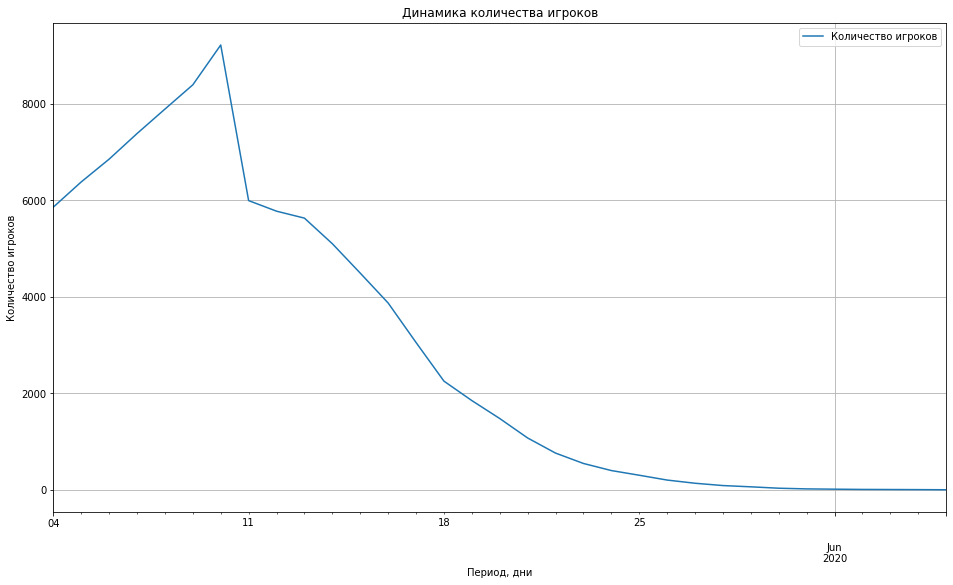

In [49]:
plot(game_actions,'date','user_id','Период, дни','Количество игроков','Количество игроков','Динамика количества игроков')

In [50]:
game_actions['project_type'].value_counts()

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

In [51]:
game_actions['source'].value_counts()

yandex_direct              47694
instagram_new_adverts      33757
facebook_ads               27672
youtube_channel_reklama    26516
Name: source, dtype: int64

In [52]:
game_actions.head(3)

,event_datetime,event,building_type,user_id,project_type,date,week,hour,play_group,source,cost
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,19,0,unfinished,youtube_channel_reklama,1068.119204
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,5,unfinished,youtube_channel_reklama,1068.119204
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,19,unfinished,youtube_channel_reklama,1068.119204


In [53]:
# срез данных по игрокам завершившим проект и победившим врага
winner=game_actions[game_actions['play_group']=='winner']
project=game_actions[game_actions['play_group']=='project']
unfinished=game_actions[game_actions['play_group']=='unfinished']

In [54]:
# срез данных по игрокам завершившим проект и победившим врага
winner_type=game_actions[(game_actions['event']!='building')&(game_actions['play_group']=='winner')]
project_type=game_actions[(game_actions['event']!='building')&(game_actions['play_group']=='project')]

In [55]:
# срез данных по игрокам разных рекламных источников
yandex=game_actions[game_actions['source']=='yandex_direct']
instagram=game_actions[game_actions['source']=='instagram_new_adverts']
facebook=game_actions[game_actions['source']=='facebook_ads']
youtube=game_actions[game_actions['source']=='youtube_channel_reklama']

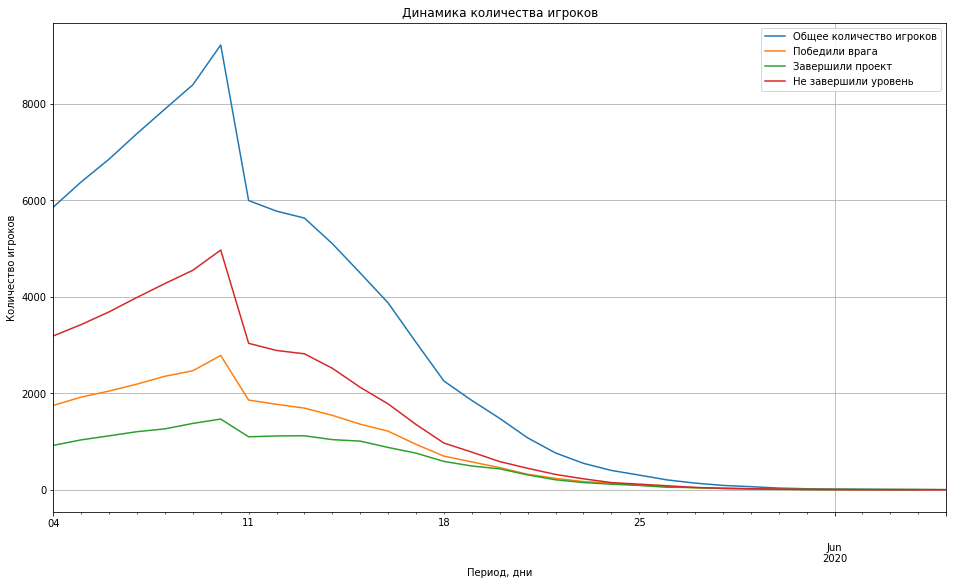

In [56]:
# сравним динамику по разным группам игроков
plot(game_actions,'date','user_id','Период, дни','Количество игроков','Общее количество игроков','Динамика количества игроков')
plot(winner,'date','user_id','Период, дни','Количество игроков','Победили врага','Динамика количества игроков')
plot(project,'date','user_id','Период, дни','Количество игроков','Завершили проект','Динамика количества игроков')
plot(unfinished,'date','user_id','Период, дни','Количество игроков','Не завершили уровень','Динамика количества игроков')
plt.show()

Динамика активности у всех групп игроков (кто не завершил уровень и кто завершил уровень разными способами). До 6-го дня произходит рост количества игроков, после 6.го дня - резкое снижение.

Посмотрим какое количество игроков завершают такие события как победа над врагом и завершения проекта

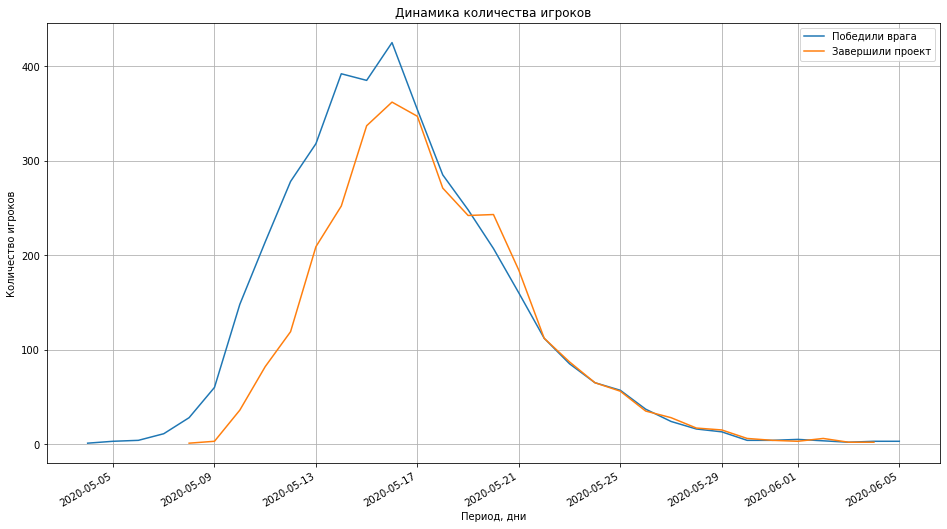

In [57]:
# сравним динамику по разным группам игроков
plot(winner_type,'date','user_id','Период, дни','Количество игроков','Победили врага','Динамика количества игроков')
plot(project_type,'date','user_id','Период, дни','Количество игроков','Завершили проект','Динамика количества игроков')

Игроки активно строят постройки, после 10 мая начинают события либо победа над врагом, либо завершнение проекта. После 15-16 мая эти события идут на спад

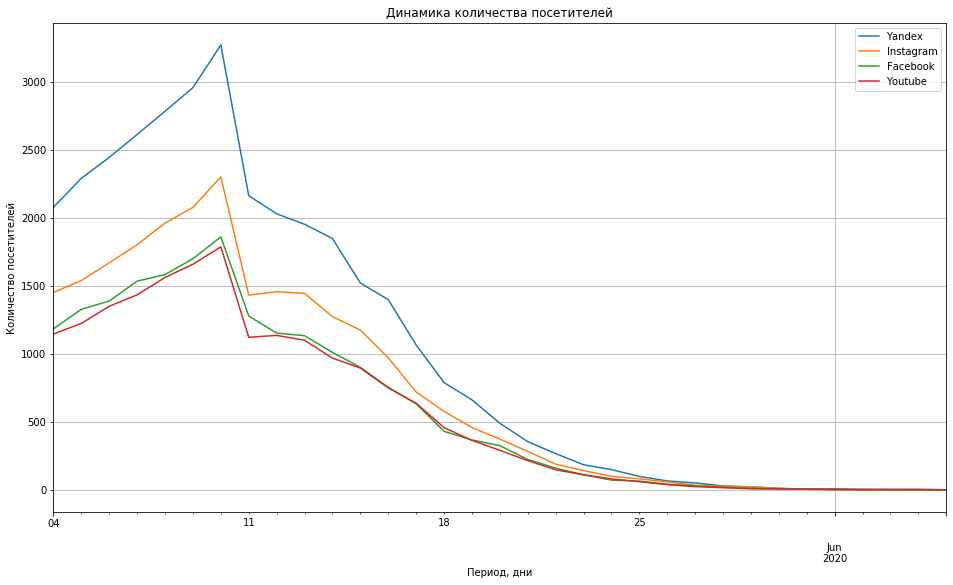

In [58]:
# сравним только игроков, которые пришли из разных рекламных источников
plot(yandex,'date','user_id','Период, дни','Количество посетителей','Yandex','Динамика количества посетителей')
plot(instagram,'date','user_id','Период, дни','Количество посетителей','Instagram','Динамика количества посетителей')
plot(facebook,'date','user_id','Период, дни','Количество посетителей','Facebook','Динамика количества посетителей')
plot(youtube,'date','user_id','Период, дни','Количество посетителей','Youtube','Динамика количества посетителей')
plt.show()

Динамика участия игороков которые либо победили врага, либо завершли проект схожа. Пик участия приходится на 15-16 мая
Динамика участия игроков пришедших  с разных рекламных источников тоже не различается, но от Yandex пришло больше всего игроков, затем от Instagram, затем Facebook и Youtube. Причем от Facebook и Youtube пришло примерно одинаковое количество игроков

Количество игроков пришедших из разных рекламных источников

In [59]:
game_actions.groupby('source')['user_id'].nunique().reset_index().sort_values(by='user_id',ascending=False)

,source,user_id
2,yandex_direct,4817
1,instagram_new_adverts,3347
0,facebook_ads,2726
3,youtube_channel_reklama,2686


Активность игроков в разный период суток

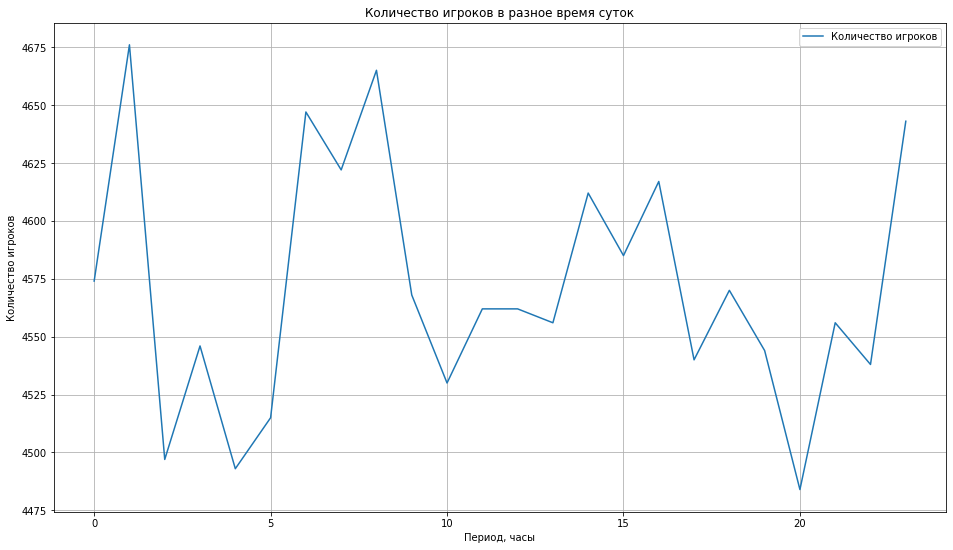

In [60]:
# Посмотрим в какие часы игроки чаще всего играют
plot(game_actions,'hour','user_id','Период, часы','Количество игроков','Количество игроков','Количество игроков в разное время суток')

Из графика видно что есть время высокой и низкой активности. Посмортим различаются ли активности у тех кто завершил проект, либо победил врага

###### Время игровой активности

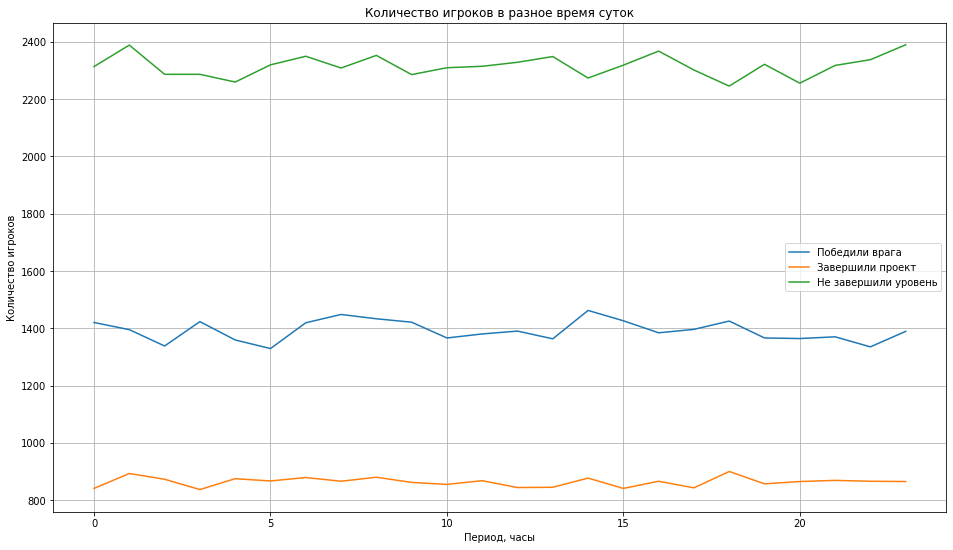

In [61]:
# сравним только игроков, которые завершили уровень 
plot(winner,'hour','user_id','Период, часы','Количество игроков','Победили врага','Количество игроков в разное время суток')
plot(project,'hour','user_id','Период, часы','Количество игроков','Завершили проект','Количество игроков в разное время суток')
plot(unfinished,'hour','user_id','Период, часы','Количество игроков','Не завершили уровень','Количество игроков в разное время суток')
plt.show()

Динамика активности у игроков которые закончили уровень разными способами схожа, но различается с теми кто не завершил уровень. Посмотрим в какое время игроки завершают уровень (исключим строительство)

In [62]:
game_actions.head(3)

,event_datetime,event,building_type,user_id,project_type,date,week,hour,play_group,source,cost
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,19,0,unfinished,youtube_channel_reklama,1068.119204
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,5,unfinished,youtube_channel_reklama,1068.119204
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,19,unfinished,youtube_channel_reklama,1068.119204


Чтобы определить в какое время суток чаще играют - разделим время на утро, день, вечер, ночь

In [63]:
#для анализа данных необходимо созать категории по распределению играков
# если в столбце type 1 - игрок завершил уровень победой
# если в столбце type 2 - игрок завершил уровень проектом
def times (time):
    if (time>=5) and (time<=11):
        return 'утро'
    if (time>=12) and (time<=16):
        return 'день'
    if (time>=17) and (time<=23):
        return 'вечер'
    if (time>=0) and (time<=4):
        return 'ночь'
    
    return 'unfinished'

game_actions['time']=game_actions['hour'].apply(times)

In [64]:
game_actions.head(3)

,event_datetime,event,building_type,user_id,project_type,date,week,hour,play_group,source,cost,time
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,19,0,unfinished,youtube_channel_reklama,1068.119204,ночь
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,5,unfinished,youtube_channel_reklama,1068.119204,утро
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,19,unfinished,youtube_channel_reklama,1068.119204,вечер


In [65]:
# срез данных по игрокам завершившим проект и победившим врага
winner=game_actions[game_actions['play_group']=='winner']
project=game_actions[game_actions['play_group']=='project']
unfinished=game_actions[game_actions['play_group']=='unfinished']

In [66]:
# срез данных по игрокам разных рекламных источников
yandex=game_actions[game_actions['source']=='yandex_direct']
instagram=game_actions[game_actions['source']=='instagram_new_adverts']
facebook=game_actions[game_actions['source']=='facebook_ads']
youtube=game_actions[game_actions['source']=='youtube_channel_reklama']

###### Распределение игроков по игровому времени

In [67]:
# по-часовая активность всех игроков
time=game_actions.groupby('time')['user_id'].nunique().reset_index().sort_values(by='user_id')

In [68]:
# по-часовая активность игроков победивших врага
time_winner=winner.groupby('time')['user_id'].nunique().reset_index().sort_values(by='user_id')
time_winner.columns=['time', 'winner']

In [69]:
# по-часовая активность игроков завершивших проект
time_project=project.groupby('time')['user_id'].nunique().reset_index().sort_values(by='user_id')
time_project.columns=['time', 'project']

In [70]:
# по-часовая активность игроков завершивших проект
time_unfinished=unfinished.groupby('time')['user_id'].nunique().reset_index().sort_values(by='user_id')
time_unfinished.columns=['time', 'unfinished']

In [71]:
# объеденим таблицы
time=time.merge(time_winner,on='time')
time=time.merge(time_project,on='time')
time=time.merge(time_unfinished,on='time')

In [72]:
# общее количество игроков 13576, из них: 1866 завершили проект,3951 победили врага, не завершили уровень 7759 
# посчитаем долю игроков в разное время суток

time['user_id,%']=(time['user_id']/13576).map('{:.2%}'.format)
time['winner,%']=(time['winner']/3951).map('{:.2%}'.format)
time['project,%']=(time['project']/1866).map('{:.2%}'.format)
time['unfinished,%']=(time['unfinished']/7759).map('{:.2%}'.format)

In [73]:
time

,time,user_id,winner,project,unfinished,"user_id,%","winner,%","project,%","unfinished,%"
0,ночь,11508,3485,1808,6215,84.77%,88.21%,96.89%,80.10%
1,день,11548,3505,1792,6251,85.06%,88.71%,96.03%,80.56%
2,утро,12481,3742,1857,6882,91.93%,94.71%,99.52%,88.70%
3,вечер,12499,3741,1852,6906,92.07%,94.68%,99.25%,89.01%


У всех групп игроков самая высокая активность утром и вечером. Игроки , которые нацелены завершить уровень реализацией проекта, участвуют практически расномерно. У игроков, которые не завершили уровень и которые завершили игру победой над врагом - чаще всего появляются утром и вечером (днем - работа, учеба, ночью - сон)

###### Распределение количества событий по игровому времени

In [74]:
# по-часовая активность всех игроков
time_event=game_actions.groupby('time')['user_id'].count().reset_index().sort_values(by='user_id')
time_event.columns=['time', 'event']

In [75]:
# по-часовая активность игроков победивших врага
time_winner_event=winner.groupby('time')['user_id'].count().reset_index().sort_values(by='user_id')
time_winner_event.columns=['time', 'event_winner']

In [76]:
# по-часовая активность игроков завершивших проект
time_unfinished_event=unfinished.groupby('time')['user_id'].count().reset_index().sort_values(by='user_id')
time_unfinished_event.columns=['time', 'event_unfin']

In [77]:
# по-часовая активность игроков завершивших проект
time_project_event=project.groupby('time')['user_id'].count().reset_index().sort_values(by='user_id')
time_project_event.columns=['time', 'event_project']

In [78]:
# объеденим таблицы
time_event=time_event.merge(time_winner_event,on='time')
time_event=time_event.merge(time_project_event,on='time')
time_event=time_event.merge(time_unfinished_event,on='time')

In [79]:
time_event

,time,event,event_winner,event_project,event_unfin
0,ночь,28140,8584,5644,13912
1,день,28262,8550,5642,14070
2,вечер,39465,11952,8024,19489
3,утро,39772,12050,8023,19699


In [80]:
# объеденим 2 таблицы
time=time.merge(time_event,on='time')

In [81]:
time

,time,user_id,winner,project,unfinished,"user_id,%","winner,%","project,%","unfinished,%",event,event_winner,event_project,event_unfin
0,ночь,11508,3485,1808,6215,84.77%,88.21%,96.89%,80.10%,28140,8584,5644,13912
1,день,11548,3505,1792,6251,85.06%,88.71%,96.03%,80.56%,28262,8550,5642,14070
2,утро,12481,3742,1857,6882,91.93%,94.71%,99.52%,88.70%,39772,12050,8023,19699
3,вечер,12499,3741,1852,6906,92.07%,94.68%,99.25%,89.01%,39465,11952,8024,19489


In [82]:
# рассчитаем среднее значение сессий игроков для каждой группы
time['session']=time['event']/time['user_id']
time['sess_win']=time['event_winner']/time['winner']
time['sess_proj']=time['event_project']/time['project']
time['sess_unfin']=time['event_unfin']/time['unfinished']

In [83]:
time

,time,user_id,winner,project,unfinished,"user_id,%","winner,%","project,%","unfinished,%",event,event_winner,event_project,event_unfin,session,sess_win,sess_proj,sess_unfin
0,ночь,11508,3485,1808,6215,84.77%,88.21%,96.89%,80.10%,28140,8584,5644,13912,2.445255,2.463128,3.121681,2.238455
1,день,11548,3505,1792,6251,85.06%,88.71%,96.03%,80.56%,28262,8550,5642,14070,2.447350,2.439372,3.148438,2.250840
2,утро,12481,3742,1857,6882,91.93%,94.71%,99.52%,88.70%,39772,12050,8023,19699,3.186604,3.220203,4.320409,2.862395
3,вечер,12499,3741,1852,6906,92.07%,94.68%,99.25%,89.01%,39465,11952,8024,19489,3.157453,3.194868,4.332613,2.822039


Также утром и вечером у игроков больше количество событий. Посмотрим игровую активность расчитав среднее количество сессий на 1 игрока

##### Игровая сессия

In [84]:
# сгруппируем ланные для расчета количества сессий и количества посетителей
sessions=game_actions.groupby('date').agg({'user_id': ['count','nunique']})
# переименуем названия столбцов
sessions.columns=['n_sessions','n_users']
# расчитаем количество сессий
sessions['session_per_user']=sessions['n_sessions']/sessions['n_users']

In [85]:
# среднее количество событий на игрока
sessions['session_per_user'].mean()

1.3334837067723855

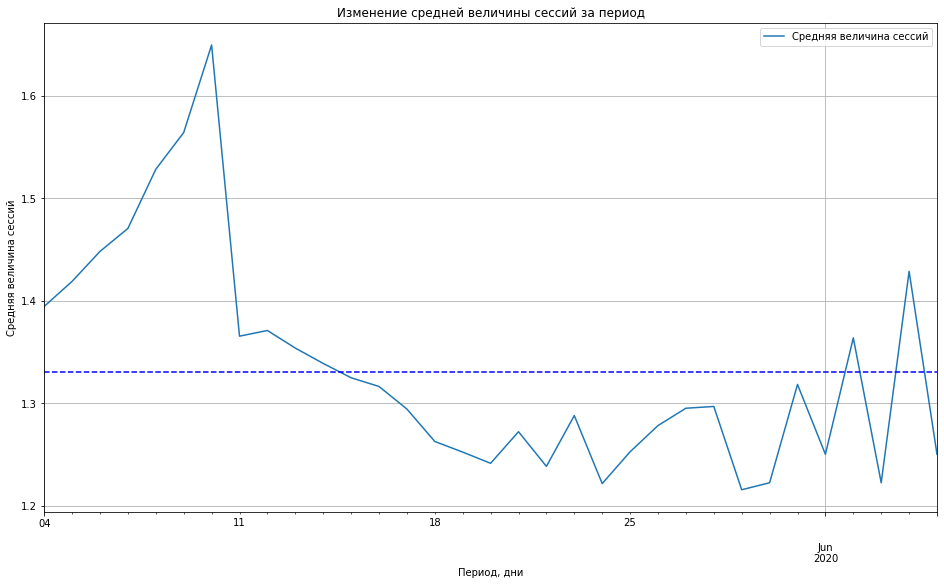

In [86]:
# посмотрим как распределялась средняя величина сессий по дням
sessions.groupby('date')['session_per_user'].max().plot(figsize=(16,9),label='Средняя величина сессий', grid=True)
plt.xlabel('Период, дни') 
plt.ylabel('Средняя величина сессий') 
plt.title('Изменение средней величины сессий за период')
plt.legend()
plt.axhline(y=1.33,color='blue', linestyle='--')

Если сравнивать с динамикой игроков - то в начале происходт рост количества пользователей, на 6-й день количество игроков снижается, то если расматривать активность игроков, то на 6-й день также снижается активность, то после 15 игрового дня активность начинает "лихорадить": то снижается, то растет. Посмотрим как меняется активность у разных групп игроков

###### Сессии у игроков победивших врага и завершившие проект

In [87]:
# группируем данные
sessions_play_group=game_actions.groupby(['play_group','date']).agg({'user_id': ['count','nunique']})
# переименуе столбцы
sessions_play_group.columns=['n_sessions','n_users']
# расчитаем количество сессий
sessions_play_group['session_per_user']=sessions_play_group['n_sessions']/sessions_play_group['n_users']

In [88]:
# среднее количество событий на игрока
sessions_play_group['session_per_user'].mean()

1.3420144511983214

In [89]:
sessions_play_group=sessions_play_group.reset_index()

In [90]:
# срез данных по игрокам завершившим проект и победившим врага
winner_session=sessions_play_group[sessions_play_group['play_group']=='winner']
project_session=sessions_play_group[sessions_play_group['play_group']=='project']
unfinished_session=sessions_play_group[sessions_play_group['play_group']=='unfinished']

In [91]:
# среднее количество событий на игрока победившего врага
winner_session['session_per_user'].mean()

1.3450170002034652

In [92]:
# среднее количество событий на игрока завершившего проект
project_session['session_per_user'].mean()

1.4423860881203652

In [93]:
# среднее количество событий на игрока не завершившего уровень
unfinished_session['session_per_user'].mean()

1.2352087576926727

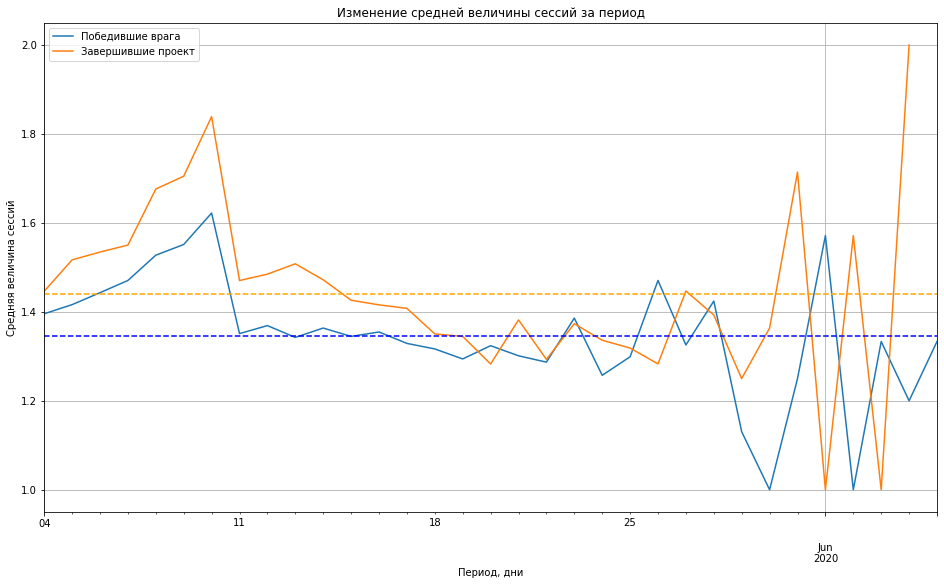

In [94]:
# посмотрим как распределялась средняя величина сессий по дням
winner_session.groupby('date')['session_per_user'].max().plot(figsize=(16,9),label='Победившие врага', grid=True)
project_session.groupby('date')['session_per_user'].max().plot(figsize=(16,9),label='Завершившие проект', grid=True)
plt.xlabel('Период, дни') 
plt.ylabel('Средняя величина сессий') 
plt.title('Изменение средней величины сессий за период')
plt.legend()
plt.axhline(y=1.345,color='blue', linestyle='--')
plt.axhline(y=1.44,color='orange', linestyle='--')
plt.show()


Хотя те группа игроков которые победили врага более много численная, но игроки которые завершили проект более активные (возможно для  разработки орбитальной сборки спутников требуется построить больше зданий, совершить больше событий)

###### Сравнения активности игроков в зависимости от рекламного источника

In [95]:
# группируем данные
sessions_source=game_actions.groupby(['source','date']).agg({'user_id': ['count','nunique']})
# переименуе столбцы
sessions_source.columns=['n_sessions','n_users']
# расчитаем количество сессий
sessions_source['session_per_user']=sessions_source['n_sessions']/sessions_source['n_users']

In [96]:
# среднее количество событий на игрока
sessions_source['session_per_user'].mean()

1.3359242014823574

In [97]:
sessions_source=sessions_source.reset_index()

In [98]:
# срез данных по игрокам разных рекламных источников
yandex_session=sessions_source[sessions_source['source']=='yandex_direct']
instagram_session=sessions_source[sessions_source['source']=='instagram_new_adverts']
facebook_session=sessions_source[sessions_source['source']=='facebook_ads']
youtube_session=sessions_source[sessions_source['source']=='youtube_channel_reklama']

In [99]:
# среднее количество событий игроков пришедших от yandex
yandex_session['session_per_user'].mean()

1.3048004664896014

In [100]:
# среднее количество событий игроков пришедших от instagram
instagram_session['session_per_user'].mean()

1.3458418952593776

In [101]:
# среднее количество событий игроков пришедших от facebook
facebook_session['session_per_user'].mean()

1.3339172114071451

In [102]:
# среднее количество событий игроков пришедших от youtube
youtube_session['session_per_user'].mean()

1.3598626400011473

In [103]:
# запишем все средние в таблицу
avg_session= pd.DataFrame({'source':['yandex_direct', 'instagram_new_adverts', 'facebook_ads', 'youtube_channel_reklama'], 'avg_session':[1.30, 1.346, 1.33, 1.359]})

In [104]:
avg_session

,source,avg_session
0,yandex_direct,1.300
1,instagram_new_adverts,1.346
2,facebook_ads,1.330
3,youtube_channel_reklama,1.359


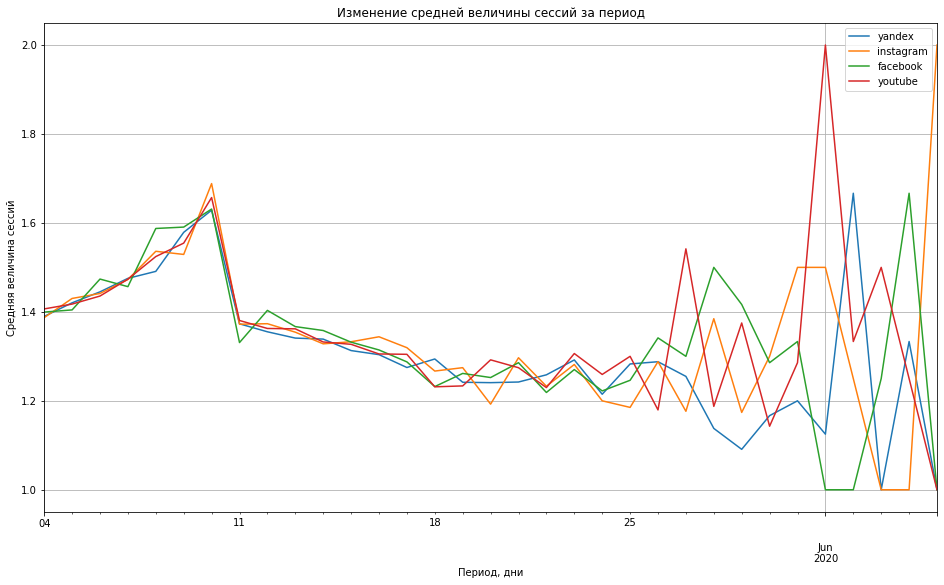

In [105]:
# посмотрим как распределялась средняя величина сессий по дням
yandex_session.groupby('date')['session_per_user'].max().plot(figsize=(16,9),label='yandex', grid=True)
instagram_session.groupby('date')['session_per_user'].max().plot(figsize=(16,9),label='instagram', grid=True)
facebook_session.groupby('date')['session_per_user'].max().plot(figsize=(16,9),label='facebook', grid=True)
youtube_session.groupby('date')['session_per_user'].max().plot(figsize=(16,9),label='youtube', grid=True)

plt.xlabel('Период, дни') 
plt.ylabel('Средняя величина сессий') 
plt.title('Изменение средней величины сессий за период')
plt.legend()
plt.show()


Активность игроков, пришедших от разных рекламных источников на первых этапах практически никак не различаются. Но вот после 21 игрового дня игровая активность меняется: высокие активности у игроков пришедших из youtube и instagram; активность игроков facebook и yandex схожа и она меньше чем у youtube и instagram. 
Активность и вовлеченность в игру это хорошо, но не менее важным фактором является - платежеспособность аудитории, желание и готовность платить. Это будет видно только после введения монетизации игры

Т.е при выборе того или иного рекламного источника можно ориентироваться:
 1) на количество пришедших игроков (1.Yandex, 2.Instagram: 3.Facebook,4.Youtube)
 2) на активность игроков (1.Youtube, 2.Instagram, 3.Facebook, 4.Yandex)
 
 Посмотрим расходы на каждый источник 

##### Анализ расходов

In [106]:
# данные о расходах даны с 03 по 09 мая, соответсвенно для расчетов сделаем срез по дате
date_cost=game_actions[(game_actions['date']>='2020-05-03')&(game_actions['date']<='2020-05-09')]

In [107]:
# группируем данные
source_cost=date_cost.groupby(['source']).agg({'user_id':'nunique','cost':'max'}).sort_values(by='user_id',ascending=False)

In [108]:
source_cost

,user_id,cost
source,,
yandex_direct,4728,2233.111449
instagram_new_adverts,3277,2161.441691
facebook_ads,2670,2140.904643
youtube_channel_reklama,2630,1068.119204


In [109]:
source_cost=source_cost.reset_index()

In [110]:
# расчитаем средние затраты на 1 игрока
source_cost['cost per user']=source_cost['cost']/source_cost['user_id']

In [111]:
source_cost

,source,user_id,cost,cost per user
0,yandex_direct,4728,2233.111449,0.472316
1,instagram_new_adverts,3277,2161.441691,0.659579
2,facebook_ads,2670,2140.904643,0.801837
3,youtube_channel_reklama,2630,1068.119204,0.406129


In [112]:
# добавим таблицу по активности пользователей
source=source_cost.merge(avg_session,on='source')

In [113]:
# средняя стоимость привлечения 1 игрока
source['cost per user'].mean()

0.5849654038074821

In [114]:
source

,source,user_id,cost,cost per user,avg_session
0,yandex_direct,4728,2233.111449,0.472316,1.300
1,instagram_new_adverts,3277,2161.441691,0.659579,1.346
2,facebook_ads,2670,2140.904643,0.801837,1.330
3,youtube_channel_reklama,2630,1068.119204,0.406129,1.359


Из 4-x рекламных источников лучше всего себя показали yandex  и youtube. Во-первых у обоих источников цена ниже средней, во-вторых yandex привлек больше всех игроков, в-третьих игроки youtube самые активные. Но случайны данные показатели или нет рассмотрим при изучение статистической значимости гипотез

#### Изучение длительности периода между событиями

У нас нет информации о начале сессий, есть инфо только об завершении событий. Можем посмотреть сколько времени в среднем игроку нужно для того чтобы перейти от одногь завершенного события к другому

In [115]:
# сместим время события на 1 строку и пропуски заполним временем события
game_actions['event_datetime_shift'] = game_actions.groupby(['user_id'])['event_datetime'].shift().\
                                                  fillna(game_actions['event_datetime'])

In [116]:
# расчитаем период (в часах) между событиями и удалим вспомогательный столбец
game_actions['period']=(game_actions['event_datetime']-game_actions['event_datetime_shift']).dt.seconds/3600
game_actions=game_actions.drop('event_datetime_shift',axis=1)

In [117]:
game_actions.head()

,event_datetime,event,building_type,user_id,project_type,date,week,hour,play_group,source,cost,time,period
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,19,0,unfinished,youtube_channel_reklama,1068.119204,ночь,0.000000
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,5,unfinished,youtube_channel_reklama,1068.119204,утро,5.337222
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,19,unfinished,youtube_channel_reklama,1068.119204,вечер,14.063056
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,19,20,unfinished,youtube_channel_reklama,1068.119204,вечер,1.588056
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-06,19,0,unfinished,youtube_channel_reklama,1068.119204,ночь,3.893611


In [118]:
# срез данных по игрокам завершившим проект и победившим врага
winner=game_actions[game_actions['play_group']=='winner']
project=game_actions[game_actions['play_group']=='project']
unfinished=game_actions[game_actions['play_group']=='unfinished']

In [119]:
# расчитаем средний период
game_actions['period'].mean()

9.419134973061757

In [120]:
winner['period'].mean()

9.60540459964781

In [121]:
project['period'].mean()

9.62380522933209

In [122]:
unfinished['period'].mean()

9.22177544538729

In [123]:
# запишем все средние в таблицу
avg_period= pd.DataFrame({'user_group':['all', 'winner', 'project', 'unfinished'], 'avg_period':[9.42, 9.61, 9.62, 9.22]})

In [124]:
avg_period

,user_group,avg_period
0,all,9.42
1,winner,9.61
2,project,9.62
3,unfinished,9.22


##### Анализ постороек

In [125]:
# общее количество событий
building_event=game_actions['building_type'].value_counts().reset_index()
building_event.columns=['building_type', 'events']

In [126]:
# какое количество игроков построили 
building_user=game_actions.groupby('building_type')['user_id'].nunique().reset_index()
building_user.columns=['building_type', 'user_id']

In [127]:
# объеденим таблицы
building=building_event.merge(building_user,on='building_type')

In [128]:
building

,building_type,events,user_id
0,spaceport,59325,13231
1,assembly_shop,54494,13576
2,research_center,14137,7671


In [129]:
# расчитаем среднее количество построек
building['avg_building']=building['events']/building['user_id']

In [130]:
building

,building_type,events,user_id,avg_building
0,spaceport,59325,13231,4.483788
1,assembly_shop,54494,13576,4.013995
2,research_center,14137,7671,1.842915


Практически все игроки построили космопорт и сборочный цех, исследовательский центр построили лишь половина.

Посмотрим как строительство происходило в динамике

In [131]:
# срез данных по игрокам завершившим проект и победившим врага
spaceport=game_actions[game_actions['building_type']=='spaceport']
assembly_shop=game_actions[game_actions['building_type']=='assembly_shop']
research_center=game_actions[game_actions['building_type']=='research_center']

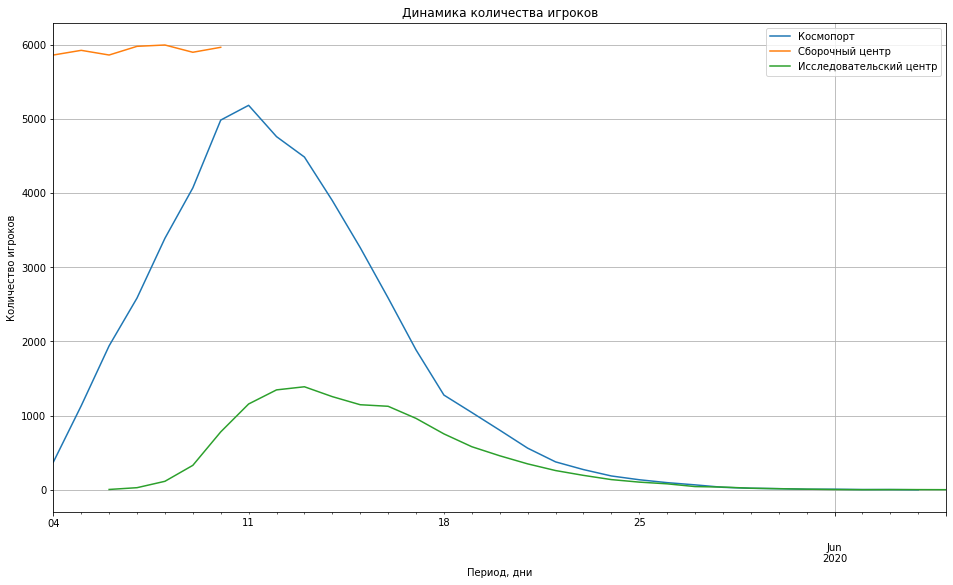

In [132]:
plot(spaceport,'date','user_id','Период, дни','Количество игроков','Космопорт','Динамика количества игроков')
plot(assembly_shop,'date','user_id','Период, дни','Количество игроков','Сборочный центр','Динамика количества игроков')
plot(research_center,'date','user_id','Период, дни','Количество игроков','Исследовательский центр','Динамика количества игроков')

Сборочный центр построили все игроки с 1 по 6-й игровой день. Возможно это основное условие чтобы пройти дальше. После 6-го игрового дня количество игроков в игре резко снижается: либо игроки не справились со следущими заданиями (построить космопорт, исследовательский центр), либо не разобрались в следующих этапах, либо потеряли интерес. Посмотрим какие группы игроков какие строили здания

In [133]:
# группируем здания
building_type=game_actions.groupby(['play_group','building_type']).agg({'user_id': ['count','nunique']})

In [134]:
# переименуе столбцы
building_type.columns=['n_sessions','n_users']
# расчитаем количество сессий
building_type['session_per_user']=building_type['n_sessions']/building_type['n_users']

In [135]:
building_type

n_sessions  n_users  session_per_user
play_group building_type                                         
project    assembly_shop          9116     1866          4.885316
           research_center        3697     1866          1.981243
           spaceport             10788     1866          5.781350
unfinished assembly_shop         29080     7759          3.747906
           research_center        6685     3463          1.930407
           spaceport             31405     7471          4.203587
winner     assembly_shop         16298     3951          4.125032
           research_center        3755     2342          1.603330
           spaceport             17132     3894          4.399589

Активность у всех игроков практически одинаковая. Все игороки завершившие уровень проектом построили все типы зданий. Игроки завершившие уровень победой: все построили сборочный цех, практически все построили космопорт, и 2/3 игроков - исследовательский центр. Игроки которые не завершили уровень: все построили сборочный цех, практически все построили космопорт, и 1/2 игроков - исследовательский центр

## Проверка статистических гипотез

<a id="cell5"></a>

In [136]:
# Функция для проверки p-value
def ttest_st(df1, df2):
    """Функция для проверки стат.гипотез (t-test Стьюдента)"""
    alpha = 0.05
    results = st.ttest_ind(df1, df2)
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу, p-value:", results.pvalue)
    else:
        print("Не получилось отвергнуть нулевую гипотезу,  p-value:", results.pvalue)

In [137]:
def mw_test(df1, df2):
    """Функция для проверки стат.гипотез (критерий Манна-Уитни)"""
    alpha = 0.05
    results = st.mannwhitneyu(df1, df2)
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу, p-value:", results.pvalue)
    else:
        print("Не получилось отвергнуть нулевую гипотезу,  p-value:", results.pvalue)

In [138]:
def test(df1, df2):
    """Функция для проверки распределения на нормальность и выбора критерия
       в зависимости от результата: нормальное распределение - t-test Стьюдента
       ненормальное - критерий Манна-Уитни
    """
    alpha = 0.05
    sh_test_result_df1 = st.shapiro(df1)
    sh_test_result_df2 = st.shapiro(df2)
    if sh_test_result_df1[1] < alpha or sh_test_result_df2[1] < alpha:
        print(f'По результатам теста Шапиро-Уилка, p-value={sh_test_result_df1[1]} распределение не нормальное\n используем критерий Манна-Уитни')
        mw_test(df1, df2)
    else:
        print(f'Распределение нормальное, используем t-test')
        ttest_st(df1, df2)

##### ГИПОТЕЗЫ:
    1. Н0 - у игроков завершивших уровень победой над врагом и у игроков завершивших уровень проектом время завершения события не различается
    2. Н1 - у игроков завершивших уровень победой над врагом и у игроков завершивших уровень проектом время завершения события различается

Расчитаем среднее время для каждой группы

In [139]:
winner['hour'].median()

11.0

In [140]:
project['hour'].median()

11.0

In [141]:
# срез данных
winner_group=game_actions[game_actions['play_group']=='winner']['hour']
project_group=game_actions[game_actions['play_group']=='project']['hour']

In [142]:
# проверяем гипотезы
test(winner_group,project_group);

По результатам теста Шапиро-Уилка, p-value=0.0 распределение не нормальное
 используем критерий Манна-Уитни
Не получилось отвергнуть нулевую гипотезу,  p-value: 0.19890057504586062


C:\Users\MaNi\anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Расчеты средней и стат значимость подтвердили что время игры у групп игроков не различается. Ранее мы выянили что самым популярным временем являются утренние и вечерние часы

##### ГИПОТЕЗЫ:
    1. Н0 - количество событий и игроков завершивших уровень победой над врагом и заершением проекта не различается
    2. Н1 - количество событий и игроков завершивших уровень победой над врагом и заершением проекта различается

In [143]:
# ранее создавали срез групп игроков
# группируем данные для проверки гипотезы
winner_group_2=winner.groupby('user_id')['building_type'].count()
project_group_2=project.groupby('user_id')['building_type'].count()

In [144]:
#расчитаем средние значения
winner_group_2.median()

10.0

In [145]:
project_group_2.median()

12.0

В среднем те кто завершает уровень разработкой орбитальной сборки спутников строят на 2 здания больше. Посмотрим является ли данное различие статистически значемым

In [146]:
# проверяем гипотезы
test(winner_group_2,project_group_2);

По результатам теста Шапиро-Уилка, p-value=1.8509618116696005e-26 распределение не нормальное
 используем критерий Манна-Уитни
Отвергаем нулевую гипотезу, p-value: 2.605963137511153e-305


Да, данное различие является статистически значемым. Игроки завершившие уровень реализацией проекта создали больше строений, т.е если планируется показ рекламы на экране при постройке зданий - этой группе игроков будет показана больше рекламы

   ##### ГИПОТЕЗЫ:
    1. Н0 - активность игроков пришедших от yandex и youtube одинаковая
    2. Н1 - активность игроков пришедших от yandex и youtube разная

In [147]:
# df для теста
yandex_test_session=yandex_session['session_per_user']
youtube_test_session=youtube_session['session_per_user']

In [148]:
#расчитаем средние значения
yandex_test_session.median()

1.2918918918918918

In [149]:
youtube_test_session.median()

1.329655135080348

Средняя величина сессий игроков которые пришли от yandex и от youtube различаются. Посмотрим является ли данное различие статистически значемым

In [150]:
# проверяем гипотезы
test(yandex_test_session,youtube_test_session);

По результатам теста Шапиро-Уилка, p-value=0.4864977300167084 распределение не нормальное
 используем критерий Манна-Уитни
Не получилось отвергнуть нулевую гипотезу,  p-value: 0.10153307239834858


З% различие между среднеми размерами количества сессий не является статистически значемым

Проверка всех гипотез показала:
    - время завершения события у игроков которые по разному завершили уровень не различается;
    - количество событий и игроков завершивших уровень победой над врагом и заершением проекта различается;
    - Активность игроков пришедших от yandex и от youtube не различаются

### ВЫВОД И РЕКОМЕНДАЦИИ

<a id="cell6"></a>

Игровые события происходят с 4 мая по 5 июня 2020 г. Закончили 1 уровень 5817 игроков: 1866 игроков разработали орбитальную сборку спутников, а остальные 3951 игроков осуществили победу над первым врагом. Не завершили уровень 7759 игроков. Игроки завершили событие building от 1 до 20 раз. В среднем каждый день играли 2884 игрока, а каждую неделю в среднем 6120. Stiky factor получился достаточно высокий (47), но следует отметить что промежуток при расчете данного показателя небольшой, т.е более реалистично он себя покажет если рассмативать более длительные сроки. На 20 недели количество пользователей практически не изменилось (89%). Резкий отток игроков произошёл на 21 недели (32% от общего количества игроков). Причем на 4-й недели из 4353 игроков играли лишь 11%. И к концу месяца в игре были менее 1 % игроков.

Динамика активности у всех групп игроков (кто не завершил уровень и кто завершил уровень разными способами). До 6-го дня произходит рост количества игроков, после 6.го дня - резкое снижение. Игроки активно строят постройки, после 10 мая начинают события либо победа над врагом, либо завершнение проекта. После 15-16 мая эти события идут на спад. Сборочный центр построили все игроки с 1 по 6-й игровой день. Возможно это основное условие чтобы пройти дальше. Активность у всех игроков практически одинаковая. Все игороки завершившие уровень проектом построили все типы зданий. Игроки завершившие уровень победой: все построили сборочный цех, практически все построили космопорт, и 2/3 игроков - исследовательский центр. Игроки которые не завершили уровень: все построили сборочный цех, практически все построили космопорт, и 1/2 игроков - исследовательский центр. После 6-го игрового дня количество игроков в игре резко снижается: либо игроки не справились со следущими заданиями (построить космопорт, исследовательский центр), либо не разобрались в следующих этапах, либо потеряли интерес.Динамика участия игроков пришедших с разных рекламных источников тоже не различается, но от Yandex пришло больше всего игроков, затем от Instagram, затем Facebook и Youtube. Причем от Facebook и Youtube пришло примерно одинаковое количество игроков. У всех групп игроков самая высокая активность утром и вечером. Игроки , которые нацелены завершить уровень реализацией проекта, участвуют практически равномерно. У игроков, которые не завершили уровень и которые завершили игру победой над врагом - чаще всего появляются утром и вечером (днем - работа, учеба, ночью - сон).  Если расматривать активность игроков, то на 6-й день также снижается активность, то после 15 игрового дня активность начинает "лихорадить". Хотя те группа игроков которые победили врага более много численная, но игроки которые завершили проект более активные. Активность игроков, пришедших от разных рекламных источников на первых этапах практически никак не различаются. Но вот после 21 игрового дня игровая активность меняется: высокие активности у игроков пришедших из youtube и instagram; активность игроков facebook и yandex схожа и она меньше чем у youtube и instagram. Активность и вовлеченность в игру это хорошо, но не менее важным фактором является - платежеспособность аудитории, желание и готовность платить. Это будет видно только после введения монетизации игры. 

Из 4-x рекламных источников лучше всего себя показали yandex и youtube. Во-первых у обоих источников цена ниже средней, во-вторых yandex привлек больше всех игроков.

Проверка всех гипотез показала:

 - время завершения события у игроков которые по разному завершили уровень не различается;
 - количество событий и игроков завершивших уровень победой над врагом и заершением проекта различается;
 - активность игроков пришедших от yandex и от youtube не различаются



#### РЕКОМЕНДАЦИИ

1. Из 4-x рекламных источников лучше всего себя показали yandex и youtube. Во-первых у обоих источников цена ниже средней, во-вторых yandex привлек больше всех игроков. НО монетизироваться игроки могут совершенно по разному: возможно рекламный источник приведет большое количество игроков, но данная аудитория будет низко платящей. Поэтому рекомендуем пользоваться всеми рекламными источниками и в дальнейшем расчитывать ARPU, ARPPU, ROI и проверить гипотезу что разные рекламные источники приводят разную платящую аудиторию. 
2. Наибольшая активность у игроков вечером и утром, поэтому следует приоритетно показывать рекламу в это время
3. 1-й этап игры состоит из постройки сборочного цеха и данный этап игроко прошли за 6 дней. Далее игроки перешли к постройке космопорта и исследовательского центра (причем космопорт построили в 2 раза больше игроков нежели исследовательский центр). Рекомендуем в первые игровые дни когорты давать рекламу на экране с выбором постройки сборочного цеха, а в дальнейшем переходить к показу рекламы при строительстве космопорта и исследовательского центра. Причем показ при строительстве космопорта должен быть в 2 раза чаще
4. На 6.й игровой день происходит отток игроков: необходимо выяснить причину оттока (не интересно, не понятна игра, сложно)
5. На 6-й также снижается игровая активность, но на 21 игровой день активность начинает меняться (начинает "лихорадить"). Также нужно выяснить причину таких изменений

#### DASHBOARD

https://public.tableau.com/views/game_16019738975640/Dashboard1?:language=en&:display_count=y&publish=yes&:origin=viz_share_link